In [1]:
import os
os.chdir('..')

In [2]:
import random
import cv2
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt

from argparse import ArgumentParser
from mpl_toolkits.axes_grid1 import ImageGrid
from pytorch_lightning import Trainer


import tqdm
import glob
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from torchvision import transforms
from argparse import ArgumentParser
from pytorch_lightning import Trainer
import pytorch_lightning.callbacks as plc
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger

from model import MInterface
from data import DInterface
from lib.train_utils import load_model_path_by_args


from preprocess.patchset import PatchSet
from lib.preprocess_utils import segment_breast,crop_img, read_resize_img, draw_rect, get_max_connected_area,convert_to_8bit

In [3]:
parser = ArgumentParser()
# Basic Training Control
parser.add_argument('--batch_size', default=32, type=int)
parser.add_argument('--num_workers', default=6, type=int)
parser.add_argument('--seed', default=1234, type=int)
parser.add_argument('--lr', default=1e-3, type=float)

# LR Scheduler
parser.add_argument('--lr_scheduler', choices=['step', 'cosine'], type=str)
parser.add_argument('--lr_decay_steps', default=20, type=int)
parser.add_argument('--lr_decay_rate', default=0.5, type=float)
parser.add_argument('--lr_decay_min_lr', default=1e-5, type=float)

# Restart Control
parser.add_argument('--load_best', action='store_true')
parser.add_argument('--load_dir', default=None, type=str)
parser.add_argument('--load_ver', default=None, type=str)
parser.add_argument('--load_v_num', default=None, type=int)

# Training Info
parser.add_argument('--dataset', default='patch_data', type=str)
parser.add_argument('--data_dir', default='data', type=str)
parser.add_argument('--csv_file', default='csv/patch_testv3.csv', type=str)
parser.add_argument('--lmdb_file', default='mdb/patch_imagesv3', type=str)
parser.add_argument('--model_name', default='standard_net', type=str)
parser.add_argument('--loss', default='bce', type=str)
parser.add_argument('--weight_decay', default=1e-5, type=float)
parser.add_argument('--no_augment', action='store_true')
parser.add_argument('--log_dir', default='logs', type=str)

# Model Hyperparameters
parser.add_argument('--hid', default=64, type=int)
parser.add_argument('--block_num', default=8, type=int)
parser.add_argument('--in_channel', default=1, type=int)
parser.add_argument('--out_channel', default=3, type=int)
parser.add_argument('--layer_num', default=5, type=int)

# Other
parser.add_argument('--aug_prob', default=0.5, type=float)

# Add pytorch lightning's args to parser as a group.
parser = Trainer.add_argparse_args(parser)

## Deprecated, old version
# parser = Trainer.add_argparse_args(
#     parser.add_argument_group(title="pl.Trainer args"))

# Reset Some Default Trainer Arguments' Default Values
parser.set_defaults(max_epochs=100)

args = parser.parse_args(args=['--lr_scheduler', 'step'])

## Evaluation

In [4]:
args.gpus = 1
args.batch_size = 4
args.dataset = 'full_img_data'
args.model_name = 'lesion_net_fcn'
args.lr_scheduler = 'step'
args.load_dir = 'logs/5_class_patch_train/version_13/checkpoints/best-epoch=24-val_acc=0.764.ckpt'
args.log_dir = 'patch_test_logs'
# List Arguments
args.mean_sen = [0.485]
args.std_sen = [0.229]
pl.seed_everything(args.seed)
load_path = load_model_path_by_args(args)
# data_module = DInterface(**vars(args))
# data_module.setup(stage='test')
if load_path is None:
    model = MInterface(**vars(args))
else:
    model = MInterface(**vars(args)).load_from_checkpoint(load_path).cuda()
    # args.resume_from_checkpoint = load_path


Global seed set to 1234
Using cache found in /home/xumingjie/.cache/torch/hub/pytorch_vision_v0.9.0


1 3


/home/xumingjie/anaconda3/envs/torchenv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


1 5


Using cache found in /home/xumingjie/.cache/torch/hub/pytorch_vision_v0.9.0


In [6]:
train_roi = pd.read_csv('/media/xumingjie/study/datasets//csv/train_roi.csv')
test_roi = pd.read_csv('/media/xumingjie/study/datasets//csv/test_roi.csv')
full_data = pd.concat([train_roi,test_roi])
full_set = PatchSet('/media/xumingjie/study/datasets/cbis-ddsm-png/',test_roi)

## random sampling

In [7]:
def calculate_confidence(heat_map, rect):
    rx,ry,rw,rh = rect
    rect_area = heat_map[ry:ry+rh, rx:rx+rw]
    score = np.max(rect_area)
    return score

In [8]:
def sampleing(mass_thr = 0.07,calc_thr = 0.16, font = cv2.FONT_HERSHEY_SIMPLEX):
    s_idx = random.randint(1, len(full_set))
    img_id,full_img,silded_patches,silde_shape,roi_areas = full_set.get_test_data(s_idx,stride = 16)
    silde_dataloader = DataLoader(silded_patches, batch_size=1)
    if not os.path.exists('asset/{}'.format(img_id)):
        os.mkdir('asset/{}'.format(img_id))
    print('asset/{}'.format(img_id))

    predictions = []

    trans =torch.nn.Sequential(
        transforms.Normalize(args.mean_sen, args.std_sen)
    )
    
    with tqdm.tqdm(total=len(silde_dataloader)) as pbar:
        for window in silde_dataloader:
            window_tensor = trans(window)
            predition = model(window_tensor.cuda())
            predictions.append(predition.cpu().detach().numpy())
            pbar.update(1)
    pred_maps = np.array(predictions).reshape(silde_shape[0],silde_shape[1],3)



    rawimg_seg = cv2.resize(
            full_img, dsize=(896,1152), 
            interpolation=cv2.INTER_CUBIC)
    # gt_seg = cv2.resize(
    #             roi_areas[0]['mask'], dsize=(896,1152), 
    #             interpolation=cv2.INTER_CUBIC)
    bkg_pred = cv2.resize(
                pred_maps[:,:,0], dsize=(896,1152), 
                interpolation=cv2.INTER_CUBIC)
    mass_pred = cv2.resize(
                pred_maps[:,:,1], dsize=(896,1152), 
                interpolation=cv2.INTER_CUBIC)
    calc_pred = cv2.resize(
                pred_maps[:,:,2], dsize=(896,1152), 
                interpolation=cv2.INTER_CUBIC)
    cv2.imwrite('asset/{}/raw.png'.format(img_id),rawimg_seg.astype(np.uint16))
    cv2.imwrite('asset/{}/mass_pred_heat_map.png'.format(img_id),convert_to_8bit(mass_pred).astype(np.uint8))
    cv2.imwrite('asset/{}/calc_pred_heat_map.png'.format(img_id),convert_to_8bit(calc_pred).astype(np.uint8))

    mass_pred_thr = np.where(mass_pred<mass_thr,0,255)
    calc_pred_thr = np.where(calc_pred<calc_thr,0,255)
    # mass_pred_8u = (mass_pred.astype('float32')*255).astype('uint8')
    # _, mass_pred_thr = cv2.threshold(mass_pred_8u, 255*0.07, maxval=255, type=cv2.THRESH_BINARY)
    
    # calc_pred_8u = (calc_pred.astype('float32')*255).astype('uint8')
    # _, calc_pred_thr = cv2.threshold(calc_pred_8u, 255*0.16, maxval=255, type=cv2.THRESH_BINARY)
    

    fig, ax = plt.subplots(1, 5+len(roi_areas))
    fig.set_figheight(15)
    fig.set_figwidth(15)
    # fig.suptitle('Horizontally stacked subplots')
    ax[0].imshow(rawimg_seg)
    ax[0].title.set_text('mammogram')
    for i in range(len(roi_areas)):
        gt_seg = cv2.resize(
                roi_areas[i]['mask'], dsize=(896,1152), 
                interpolation=cv2.INTER_CUBIC)
        cv2.imwrite('asset/{}/lesion_mask_{}_{}_{}.png'.format(img_id,i,roi_areas[i]['type'],roi_areas[i]['pathology']),gt_seg)

        ax[i+1].imshow(gt_seg)
        ax[i+1].title.set_text('{} mask'.format(roi_areas[i]['type']))
    # ax[-3].imshow(bkg_pred)
    # ax[-3].title.set_text('normal area prediction')

    ax[-4].imshow(mass_pred)
    ax[-4].title.set_text('mass area pred')
    ax[-3].imshow(mass_pred_thr)
    ax[-3].title.set_text('mass pred bin')


    ax[-2].imshow(calc_pred)
    ax[-2].title.set_text('calc area pred')
    ax[-1].imshow(calc_pred_thr)
    ax[-1].title.set_text('mass pred bin')

    plt.savefig('asset/{}/predictions.png'.format(img_id))


    img_8u = (rawimg_seg.astype('float32')/rawimg_seg.max()*255).astype('uint8')
    rawimg_rgb = cv2.cvtColor(img_8u,cv2.COLOR_GRAY2RGB)
    area_thr = 30

    num_mass_gt = 0
    num_calc_gt = 0
    for i in range(len(roi_areas)):
        gt_seg = cv2.resize(
                roi_areas[i]['mask'], dsize=(896,1152), 
                interpolation=cv2.INTER_CUBIC)
        idx,cont_areas,contours = get_max_connected_area(gt_seg)
        for contour in contours:
            rx,ry,rw,rh = cv2.boundingRect(contour)
            if rw *rh >area_thr:
                if roi_areas[i]['type'] == 'mass':
                    color = (0,0,255)
                    num_mass_gt +=1
                else:
                    color = (255,0,0)
                    num_calc_gt +=1
                cv2.rectangle(rawimg_rgb,(rx,ry),(rx+rw, ry+rh), color, 1)
                cv2.putText(rawimg_rgb,'pathology:{}'.format(roi_areas[i]['pathology']),(rx,ry-10), font,0.5, color, 1, cv2.LINE_AA)

    num_mass_candidates = 0
    idx,cont_areas,contours = get_max_connected_area(mass_pred_thr)
    for contour in contours:
        rx,ry,rw,rh = cv2.boundingRect(contour)
        if 1152/10<ry<1152*9/10:
            num_mass_candidates +=1
            confidence = calculate_confidence(mass_pred, (rx,ry,rw,rh))
            cv2.rectangle(rawimg_rgb,(rx,ry),(rx+rw, ry+rh), (193,182,255), 1)
            cv2.putText(rawimg_rgb,'score:{:.2f}'.format(confidence),(rx,ry-10), font, 0.5, (193,182,255), 1, cv2.LINE_AA)
    num_calc_candidates = 0
    idx,cont_areas,contours = get_max_connected_area(calc_pred_thr)
    for contour in contours:
        # if 1152/10<ry<1152*9/10:
        rx,ry,rw,rh = cv2.boundingRect(contour)
        if 1152/10<ry<1152*9/10:
            num_calc_candidates+=1
            confidence = calculate_confidence(calc_pred, (rx,ry,rw,rh))
            cv2.rectangle(rawimg_rgb,(rx,ry),(rx+rw, ry+rh), (255,191,0), 1)
            cv2.putText(rawimg_rgb,'score:{:.2f}'.format(confidence),(rx,ry-10), font,0.5, (255,191,0), 1, cv2.LINE_AA)

    
    cv2.putText(rawimg_rgb,'mass ground truth:{}'.format(num_mass_gt),(10,20), font, 1, (0,0,255), 1, cv2.LINE_AA)
    cv2.putText(rawimg_rgb,'mass candidate:{}'.format(num_mass_candidates),(10,50), font, 1, (193,182,255), 1, cv2.LINE_AA)

    cv2.putText(rawimg_rgb,'calc ground truth:{}'.format(num_calc_gt),(10,100), font, 1, (255,0,0), 1, cv2.LINE_AA)
    cv2.putText(rawimg_rgb,'calc candidate:{}'.format(num_calc_candidates),(10,130), font, 1, (255,191,0), 1, cv2.LINE_AA)

    cv2.imwrite('asset/{}/pred boxes.png'.format(img_id),rawimg_rgb)

In [11]:
for _ in range(20):
    sampleing()

AttributeError: 

In [192]:
s_idx = random.randint(1, len(full_set))
img_id,full_img,silded_patches,silde_shape,roi_areas = full_set.get_test_data(s_idx,stride = 16)
silde_dataloader = DataLoader(silded_patches, batch_size=1)

In [193]:
if not os.path.exists('asset/{}'.format(img_id)):
    os.mkdir('asset/{}'.format(img_id))
print('asset/{}'.format(img_id))


asset/Mass-Test_P_00928_RIGHT_CC


In [194]:
predictions = []

trans =torch.nn.Sequential(
    transforms.Normalize(args.mean_sen, args.std_sen)
)
with tqdm.tqdm(total=len(silde_dataloader)) as pbar:
    for window in silde_dataloader:
        window_tensor = trans(window)
        predition = model(window_tensor.cuda())
        predictions.append(predition.cpu().detach().numpy())
        pbar.update(1)

100%|██████████| 2263/2263 [00:29<00:00, 77.78it/s]


In [195]:
pred_maps = np.array(predictions).reshape(silde_shape[0],silde_shape[1],3)

In [196]:
rawimg_seg = cv2.resize(
            full_img, dsize=(896,1152), 
            interpolation=cv2.INTER_CUBIC)
# gt_seg = cv2.resize(
#             roi_areas[0]['mask'], dsize=(896,1152), 
#             interpolation=cv2.INTER_CUBIC)
bkg_pred = cv2.resize(
            pred_maps[:,:,0], dsize=(896,1152), 
            interpolation=cv2.INTER_CUBIC)
mass_pred = cv2.resize(
            pred_maps[:,:,1], dsize=(896,1152), 
            interpolation=cv2.INTER_CUBIC)
calc_pred = cv2.resize(
            pred_maps[:,:,2], dsize=(896,1152), 
            interpolation=cv2.INTER_CUBIC)
cv2.imwrite('asset/{}/raw.png'.format(img_id),rawimg_seg.astype(np.uint16))
cv2.imwrite('asset/{}/mass_pred_heat_map.png'.format(img_id),convert_to_8bit(mass_pred).astype(np.uint8))
cv2.imwrite('asset/{}/calc_pred_heat_map.png'.format(img_id),convert_to_8bit(calc_pred).astype(np.uint8))

True

In [197]:
mass_pred_8u = (mass_pred.astype('float32')/calc_pred.max()*255).astype('uint8')
_, mass_pred_thr = cv2.threshold(mass_pred_8u, 100, maxval=255, type=cv2.THRESH_BINARY)

calc_pred_8u = (calc_pred.astype('float32')/calc_pred.max()*255).astype('uint8')
_, calc_pred_thr = cv2.threshold(calc_pred_8u, 180, maxval=255, type=cv2.THRESH_BINARY)

Mass-Test_P_00928_RIGHT_CC


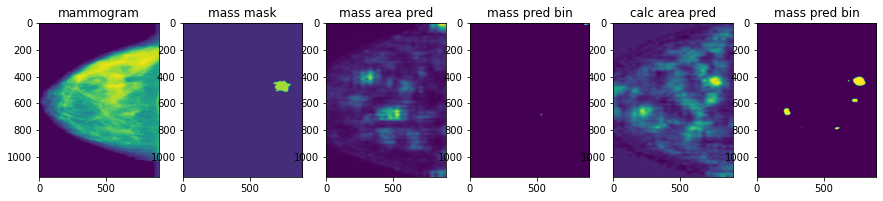

In [198]:
print(img_id)
fig, ax = plt.subplots(1, 5+len(roi_areas))
fig.set_figheight(15)
fig.set_figwidth(15)
# fig.suptitle('Horizontally stacked subplots')
ax[0].imshow(rawimg_seg)
ax[0].title.set_text('mammogram')
for i in range(len(roi_areas)):
    gt_seg = cv2.resize(
            roi_areas[i]['mask'], dsize=(896,1152), 
            interpolation=cv2.INTER_CUBIC)
    cv2.imwrite('asset/{}/lesion_mask_{}_{}_{}.png'.format(img_id,i,roi_areas[i]['type'],roi_areas[i]['pathology']),gt_seg)

    ax[i+1].imshow(gt_seg)
    ax[i+1].title.set_text('{} mask'.format(roi_areas[i]['type']))
# ax[-3].imshow(bkg_pred)
# ax[-3].title.set_text('normal area prediction')

ax[-4].imshow(mass_pred)
ax[-4].title.set_text('mass area pred')
ax[-3].imshow(mass_pred_thr)
ax[-3].title.set_text('mass pred bin')


ax[-2].imshow(calc_pred)
ax[-2].title.set_text('calc area pred')
ax[-1].imshow(calc_pred_thr)
ax[-1].title.set_text('mass pred bin')

plt.savefig('asset/{}/predictions.png'.format(img_id))

In [199]:
img_8u = (rawimg_seg.astype('float32')/rawimg_seg.max()*255).astype('uint8')
rawimg_rgb = cv2.cvtColor(img_8u,cv2.COLOR_GRAY2RGB)
area_thr = 20

for i in range(len(roi_areas)):
    gt_seg = cv2.resize(
            roi_areas[i]['mask'], dsize=(896,1152), 
            interpolation=cv2.INTER_CUBIC)
    idx,cont_areas,contours = get_max_connected_area(gt_seg)

    if roi_areas[i]['type'] == 'mass':
        color = (0,0,255)
    else:
        color = (255,0,0)

    for contour in contours:   
        rx,ry,rw,rh = cv2.boundingRect(contour)
        if rw *rh >area_thr:
            cv2.rectangle(rawimg_rgb,(rx,ry),(rx+rw, ry+rh), color, 1)


idx,cont_areas,contours = get_max_connected_area(mass_pred_thr)
for contour in contours:
    rx,ry,rw,rh = cv2.boundingRect(contour)
    if 1152/10<ry<1152*9/10:   
        cv2.rectangle(rawimg_rgb,(rx,ry),(rx+rw, ry+rh), (193,182,255), 1)

idx,cont_areas,contours = get_max_connected_area(calc_pred_thr)
for contour in contours:
    # if 1152/10<ry<1152*9/10:
    rx,ry,rw,rh = cv2.boundingRect(contour)
    if 1152/10<ry<1152*9/10:
        cv2.rectangle(rawimg_rgb,(rx,ry),(rx+rw, ry+rh), (255,191,0), 1)

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(rawimg_rgb,'mass ground truth',(10,20), font, 1, (0,0,255), 1, cv2.LINE_AA)
cv2.putText(rawimg_rgb,'mass candidate',(10,50), font, 1, (193,182,255), 1, cv2.LINE_AA)

cv2.putText(rawimg_rgb,'calc ground truth',(10,100), font, 1, (255,0,0), 1, cv2.LINE_AA)
cv2.putText(rawimg_rgb,'calc candidate',(10,130), font, 1, (255,191,0), 1, cv2.LINE_AA)

cv2.imwrite('asset/{}/pred boxes.png'.format(img_id),rawimg_rgb)

True